In [1]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_ta as ta   # pandas-ta provides technical indicators
from pathlib import Path

# plotting defaults
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (12,5)
DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)


In [13]:
def fetch_price(ticker, start="2018-01-01", end=None, interval="1d"):
    """
    Universal yfinance fetcher (Python 3.13 compatible)
    Works even when Adj Close is missing.
    """

    df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)

    if df.empty:
        raise ValueError(f"No data returned for ticker {ticker}")

    # Make index datetime
    df.index = pd.to_datetime(df.index)

    # Reset the index into a column called datetime
    df = df.reset_index().rename(columns={
        "index": "datetime",
        "Date": "datetime"
    })

    # Ensure OHLCV consistency
    expected_cols = ["Open", "High", "Low", "Close", "Volume"]

    # Add missing columns if needed
    for col in expected_cols:
        if col not in df.columns:
            df[col] = None  # create blank column

    # Handle adjusted close
    if "Adj Close" in df.columns:
        df = df.rename(columns={"Adj Close": "Adj_Close"})
    else:
        df["Adj_Close"] = df["Close"]  # fallback if missing

    # Final selection
    df = df[["datetime", "Open", "High", "Low", "Close", "Adj_Close", "Volume"]]

    # Make datetime the index again
    df = df.set_index("datetime")

    return df


In [14]:
ticker = "AAPL"
df = fetch_price(ticker, start="2020-01-01")
df.head()


C:\Users\Owner\AppData\Local\Temp\ipykernel_16420\2802191777.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)


Price,Open,High,Low,Close,Adj_Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,,AAPL
datetime,,,,,,
2020-01-02,71.476607,72.528589,71.223267,72.468269,72.468269,135480400
2020-01-03,71.696183,72.523769,71.539352,71.763741,71.763741,146322800
2020-01-06,70.885464,72.374154,70.634532,72.335548,72.335548,118387200
2020-01-07,72.345212,72.600968,71.775796,71.995361,71.995361,108872000
2020-01-08,71.698589,73.455103,71.698589,73.153503,73.153503,132079200


In [15]:
df.columns = df.columns.droplevel(1)


In [16]:
print(df.columns.tolist())
df.head()


['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']


Price,Open,High,Low,Close,Adj_Close,Volume
datetime,,,,,,
2020-01-02,71.476607,72.528589,71.223267,72.468269,72.468269,135480400
2020-01-03,71.696183,72.523769,71.539352,71.763741,71.763741,146322800
2020-01-06,70.885464,72.374154,70.634532,72.335548,72.335548,118387200
2020-01-07,72.345212,72.600968,71.775796,71.995361,71.995361,108872000
2020-01-08,71.698589,73.455103,71.698589,73.153503,73.153503,132079200


In [17]:
# Use adjusted close for returns
df['close'] = df['Adj_Close']
df['return'] = df['close'].pct_change()
df['log_return'] = np.log(df['close']).diff()
df.dropna(subset=['close'], inplace=True)


In [19]:
df.tail()

Price,Open,High,Low,Close,Adj_Close,Volume,close,return,log_return
datetime,,,,,,,,,
2025-11-17,268.820007,270.489990,265.730011,267.459991,267.459991,45018300,267.459991,-0.018171,-0.018338
2025-11-18,269.989990,270.709991,265.320007,267.440002,267.440002,45677300,267.440002,-0.000075,-0.000075
2025-11-19,265.529999,272.209991,265.500000,268.559998,268.559998,40424500,268.559998,0.004188,0.004179
2025-11-20,270.829987,275.429993,265.920013,266.250000,266.250000,45823600,266.250000,-0.008601,-0.008639
2025-11-21,265.950012,273.329987,265.670013,271.489990,271.489990,58784100,271.489990,0.019681,0.019490


In [20]:
# Moving averages: simple 20 & 50
df['MA20'] = ta.sma(df['close'], length=20)
df['MA50'] = ta.sma(df['close'], length=50)

# RSI (14)
df['RSI14'] = ta.rsi(df['close'], length=14)

# MACD (12,26,9)
macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
# macd returns a DataFrame with columns MACD_12_26_9, MACDs_12_26_9, MACDh_12_26_9
df = pd.concat([df, macd], axis=1)

# Volume rolling average (optional)
df['vol_ma20'] = df['Volume'].rolling(20).mean()

df.tail(3)


,Open,High,Low,Close,Adj_Close,Volume,close,return,log_return,MA20,MA50,RSI14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,vol_ma20
datetime,,,,,,,,,,,,,,,,
2025-11-19,265.529999,272.209991,265.500000,268.559998,268.559998,40424500,268.559998,0.004188,0.004179,269.150116,257.807293,56.416055,3.726441,-1.088898,4.815339,48561435.0
2025-11-20,270.829987,275.429993,265.920013,266.250000,266.250000,45823600,266.250000,-0.008601,-0.008639,269.496187,258.536149,51.762799,3.206074,-1.287412,4.493486,49214870.0
2025-11-21,265.950012,273.329987,265.670013,271.489990,271.489990,58784100,271.489990,0.019681,0.019490,269.942412,259.289082,59.852250,3.179848,-1.050911,4.230759,50241390.0


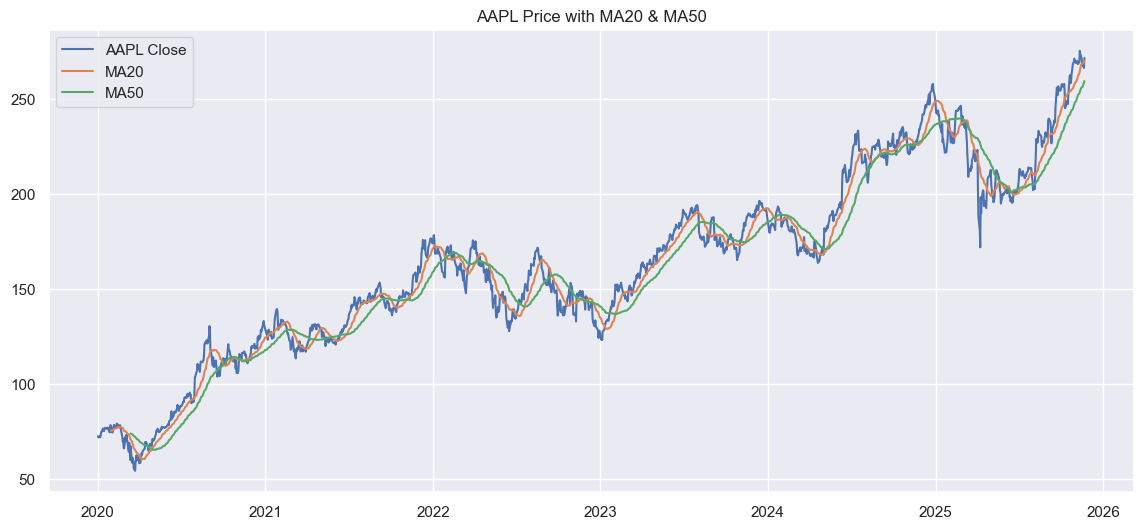

In [21]:
plt.figure(figsize=(14,6))
plt.plot(df['close'], label=f"{ticker} Close")
plt.plot(df['MA20'], label="MA20")
plt.plot(df['MA50'], label="MA50")
plt.title(f"{ticker} Price with MA20 & MA50")
plt.legend()
plt.show()


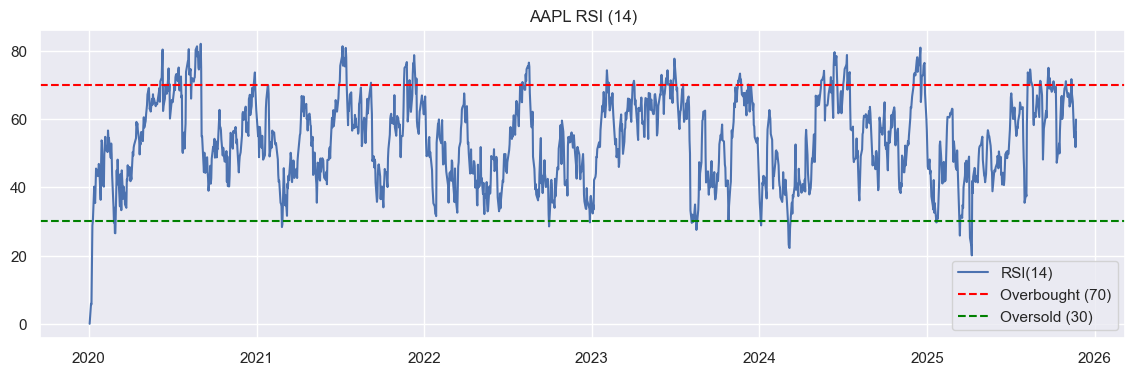

In [22]:
plt.figure(figsize=(14,4))
plt.plot(df['RSI14'], label='RSI(14)')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title(f"{ticker} RSI (14)")
plt.legend()
plt.show()


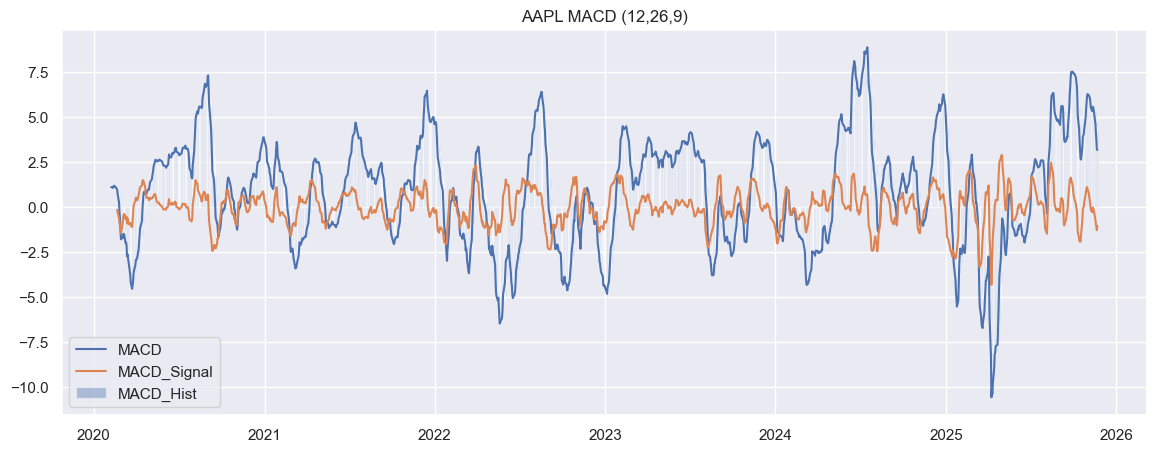

In [23]:
plt.figure(figsize=(14,5))
plt.plot(df[macd.columns[0]], label='MACD')
plt.plot(df[macd.columns[1]], label='MACD_Signal')
plt.bar(df.index, df[macd.columns[2]], label='MACD_Hist', alpha=0.4)
plt.title(f"{ticker} MACD (12,26,9)")
plt.legend()
plt.show()


In [24]:
# Try using pynance for financial metrics; fallback if not installed
try:
    import pynance as pn
    has_pynance = True
except Exception:
    has_pynance = False

# Compute common financial metrics: daily mean return, vol, annualized vol, sharpe (annualized)
metrics = {}
returns = df['return'].dropna()
metrics['mean_daily_return'] = returns.mean()
metrics['daily_vol'] = returns.std()
metrics['annualized_return'] = returns.mean() * 252
metrics['annualized_vol'] = returns.std() * (252 ** 0.5)
metrics['sharpe_annual'] = metrics['annualized_return'] / metrics['annualized_vol'] if metrics['annualized_vol']>0 else np.nan

# If pynance is available, compute a few extra metrics
if has_pynance:
    try:
        # Example pynance usage (may vary based on pynance API)
        metrics['pynance_sharpe'] = pn.metrics.sharpe(returns)
    except Exception:
        pass

metrics


{'mean_daily_return': np.float64(0.0010952266137410642),
 'daily_vol': np.float64(0.020187733520520643),
 'annualized_return': np.float64(0.2759971066627482),
 'annualized_vol': np.float64(0.32047033457604046),
 'sharpe_annual': np.float64(0.8612251334522828)}

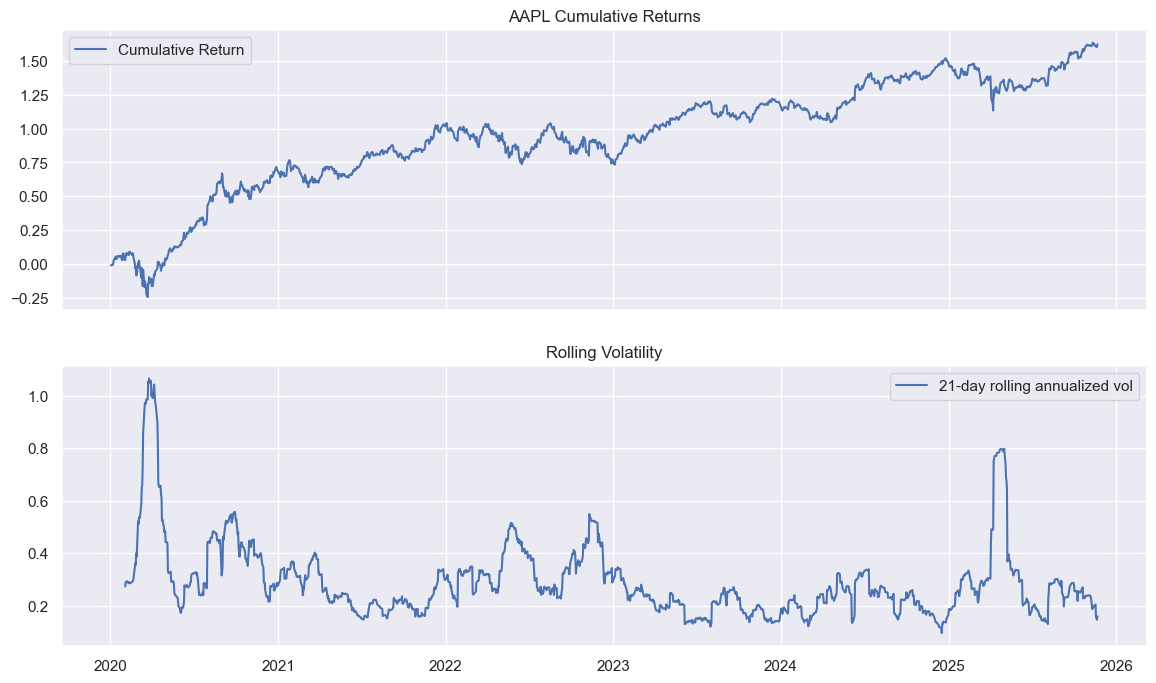

In [25]:
fig, ax = plt.subplots(2,1, figsize=(14,8), sharex=True)
ax[0].plot(returns.cumsum(), label='Cumulative Return')
ax[0].set_title(f'{ticker} Cumulative Returns')
ax[0].legend()

ax[1].plot(returns.rolling(21).std() * (252 ** 0.5), label='21-day rolling annualized vol')
ax[1].set_title('Rolling Volatility')
ax[1].legend()
plt.show()


In [26]:
# Prepare dataset for correlation: shift next-day return column
df['next_return'] = df['return'].shift(-1)
cols = ['MA20','MA50','RSI14', macd.columns[0], macd.columns[1], macd.columns[2], 'vol_ma20']
corr_df = df[cols + ['next_return']].dropna()
corr = corr_df.corr()['next_return'].sort_values(ascending=False)
corr


next_return      1.000000
vol_ma20         0.027180
RSI14           -0.018658
MACDs_12_26_9   -0.023866
MACD_12_26_9    -0.033919
MACDh_12_26_9   -0.036904
MA50            -0.049296
MA20            -0.051031
Name: next_return, dtype: float64

# Summary
- Loaded OHLCV for ticker: AAPL
- Computed MA20, MA50, RSI14, MACD, rolling volume
- Computed returns, annualized vol and Sharpe
- Visualized price, indicators and returns
# Next steps
- Merge with news sentiment daily aggregates (Task 3)
- Run lagged correlation tests and Granger causality
- Backtest simple signal based on sentiment + indicators
